# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11
!pip install tokenizers
!pip install torchdata==0.5.1
!pip install -Uqq git+https://github.com/fastai/course22p2 --cache-dir /content/drive/MyDrive/pip_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [4]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
from types import SimpleNamespace

In [7]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [8]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [9]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

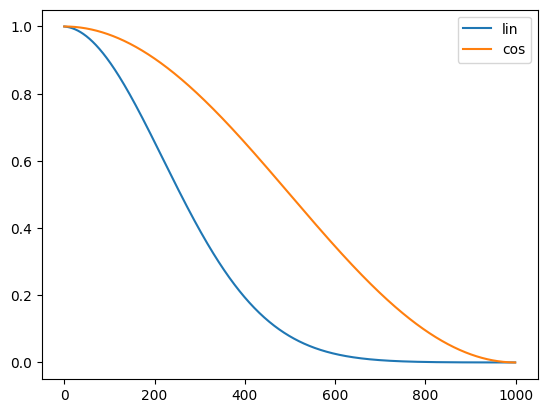

In [10]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

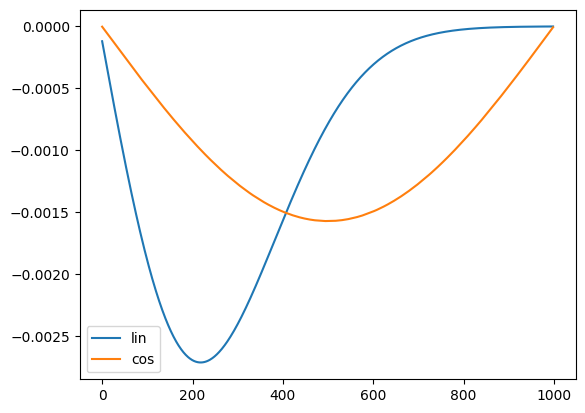

In [11]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

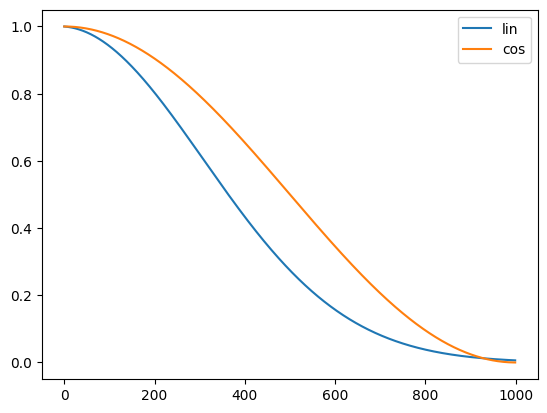

In [12]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

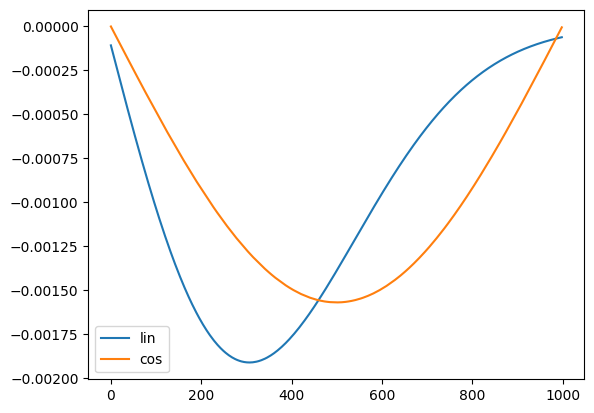

In [13]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [14]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [15]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [16]:
dt = dls.train
xb,yb = next(iter(dt))

In [17]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

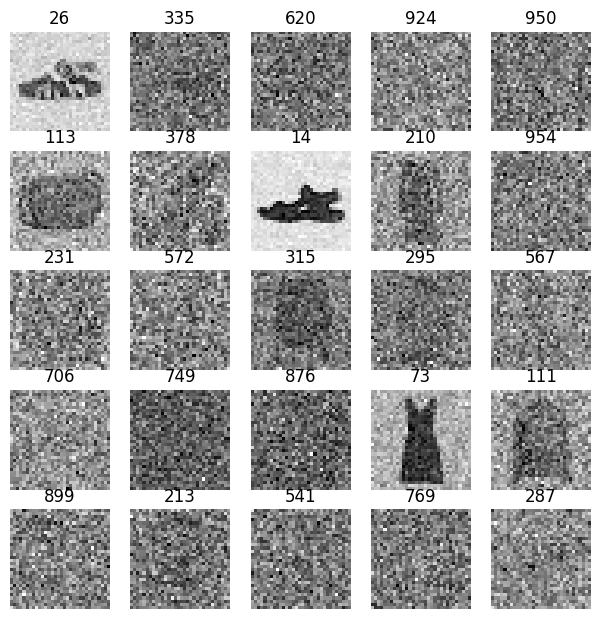

In [18]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

In [19]:
from diffusers import UNet2DModel

0it [00:00, ?it/s]

In [20]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [21]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [22]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [23]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [25]:
import torch
torch.cuda.is_available()

False

In [1]:
learn.fit(epochs)

NameError: name 'learn' is not defined

In [ ]:
mdl_path = Path('models')

In [ ]:
# torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [ ]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
n_samples = 512

In [ ]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 2min 14s, sys: 630 ms, total: 2min 15s
Wall time: 2min 15s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.0958), tensor(1.4350))

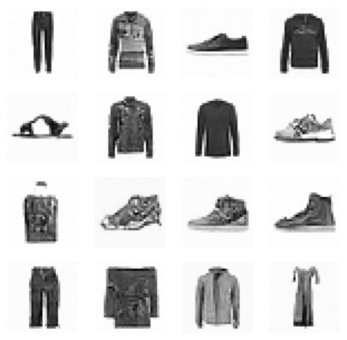

In [ ]:
show_images(s[:16], imsize=1.5)

In [ ]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
from miniai.fid import ImageEval

In [ ]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [ ]:
ie.fid(s)

8.116404992630578

In [ ]:
s.min(),s.max()

(tensor(-1.0958), tensor(1.4350))

In [ ]:
ie.fid(xb*2)

6.614931741843861

### Skip sampling

In [ ]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [ ]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 50.4 s, sys: 404 ms, total: 50.8 s
Wall time: 50.8 s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

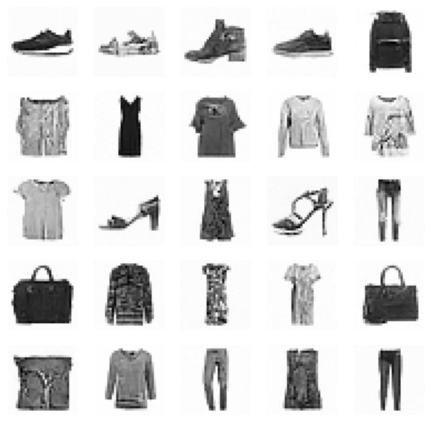

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

9.782707549767224

In [ ]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 41.3 s, sys: 108 ms, total: 41.4 s
Wall time: 41.4 s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

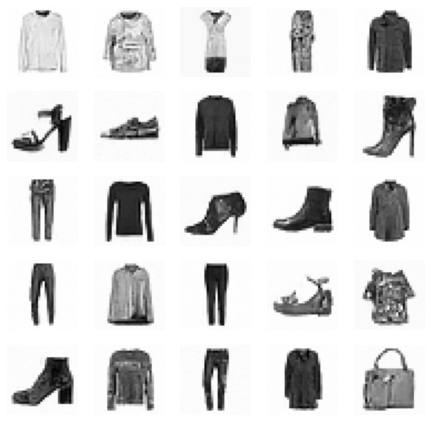

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

11.869442925448084